{{ badge }}

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

import scipy as sp

# Memorization, bad and good generalization - does the Hessian see the difference?

In this notebook, we will play with a basic neural network and a basic artificial dataset based on three Gaussians. We will train the network in three different ways, achieving different test errors and different complexities of the solutions.

The code is based on *Unveiling the Hessian’s Connection to the Decision Boundary* by Mahalakshmi Sabanayagam, Freya Behrens, Urte Adomaityte and Anna Dawid ([arXiv](https://arxiv.org/abs/2306.07104) + [GitHub](https://github.com/Shmoo137/Hessian-and-Decision-Boundary)).

## The cases are the following:
1. Normal training
2. Training on the same data but randomized labels.
3. Normal training BUT from an "adversarial initialization", that is, the solution to the random-label dataset. (You first need to do Case 2, then avoid re-initializing the model, just continue with the training).

## For every case, we will:
- train a network, plot its training and validation performance vs epochs,
- compute the Hessian of the training loss at the minimum and plot its spectrum,
- visualize the 2D input space and the decision boundaries learned by the network.

## What I prepared for you already:
1. Definition of the network, e.g., `FullyConnectedNetwork`.
2. Definition of the Gaussian dataset, `GaussianDataset`.
3. Definition of plotting functions for visualizing the input space and decision boundaries.
4. Definition of functions to compute the Hessian.
5. Case 1. Normal training.

## I encourage you to:
1. Realize cases 2 and 3. Compare decision boundaries learned in cases 1-3. Compare spectra of Hessians achieved in cases 1-3. Any differences? Any ideas from where they come from?
2. Plot Hessian spectra across the normal training, see how it changes. Is its speed similar throughout the training? If not, any idea why? (connection to the lecture?)

### 1. Definition of the model `FullyConnectedNetwork`.
You will later initialize an instance of the model with:

```
model = FullyConnectedNetwork(2, 100, 100, 3)
```
Input size is 2, because in the next cell I will define the Gaussians as the 2D dataset, output size is 3, because I will define three Gaussians (three classes of points) with different means and variances. Feel free to modify the number of hidden neurons (especially if computing the Hessian and its spectrum takes too much time).


In [3]:
# Define here your neural network class
class FullyConnectedNetwork(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(FullyConnectedNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

### 2. Definition of the Gaussian dataset, `GaussianDataset`

Here you can redefine their means, variances, number of samples, and ratio between training, validation, and test data size.

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader

class GaussianDataset(Dataset):
    def __init__(self, means, variances, num_samples, labels_type="true"):
        self.means = means
        self.variances = variances
        self.num_samples = num_samples
        self.labels_type = labels_type
        self.data = []
        self.labels_true = []
        self.labels_random = []

        for i, (mean, variance) in enumerate(zip(self.means, self.variances)):
            cov = np.array([[variance[0], 0], [0, variance[1]]])
            gaussian_samples = np.random.multivariate_normal(mean, cov, num_samples)
            self.data.extend(gaussian_samples.tolist())
            self.labels_true.extend([i] * self.num_samples)

        for _ in range(len(self.data)):
          self.labels_random.append(torch.randint(0,3,(1,)).item())

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        if self.labels_type == "true":
            return torch.tensor(self.data[index], dtype=torch.float32), torch.tensor(self.labels_true[index], dtype=torch.long)
        # Here, I already prepared for you the random labeling for case 2.
        elif self.labels_type == "random":
            return torch.tensor(self.data[index], dtype=torch.float32), torch.tensor(self.labels_random[index], dtype=torch.long)
        else:
            raise ValueError("Invalid labels_type. Choose 'true' or 'random'.")


# Define means and variances (covariances are set to zero in the code above)
means = [[2,-1], [-2,0], [0,2]]
variances = [[0.5,0.5], [0.5,1], [0.5,0.5]]
num_samples = 500  # number of data points from each Gaussian distribution

# Create the datasets
# When working on case 2, set labels_type to "random"
train_dataset = GaussianDataset(means, variances, num_samples // 2, labels_type = "true")
val_dataset = GaussianDataset(means, variances, num_samples // 4, labels_type = "true")
test_dataset = GaussianDataset(means, variances, num_samples // 4, labels_type = "true")

# Create the data loaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#### You can plot the training data if you want

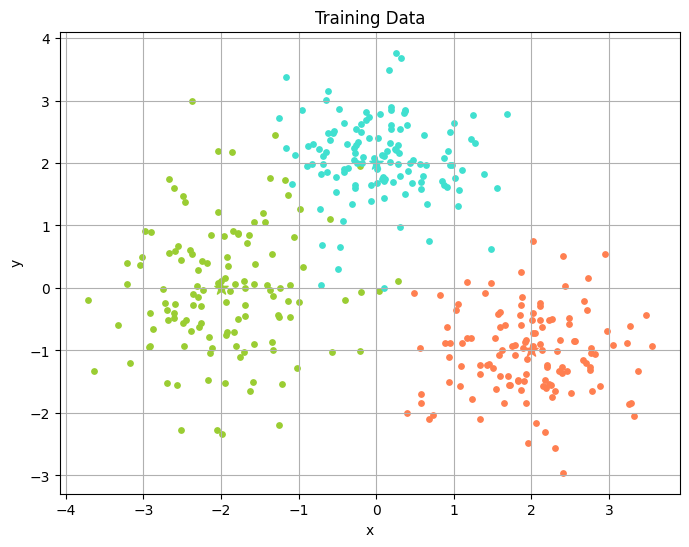

In [5]:
# Plot training data
colors = ["coral", "yellowgreen", "turquoise"]
plt.figure(figsize=(8, 6))
for i in range(len(test_dataset.data)):
  plt.scatter(test_dataset.data[i][0], test_dataset.data[i][1], c=colors[test_dataset.labels_true[i]], s=15)
for j in range(3):
  plt.scatter(means[j][0], means[j][1], c=colors[j], s=100, marker="*")
plt.title('Training Data')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

### 3. Plotting functions.

Feel free to ignore the insides. Just know what they input and output.

In [6]:
# Give boundaries and density of your meshgrid
def generate_grid_data(min_x, max_x, min_y, max_y, dim_x, dim_y):
    x1 = np.linspace(min_x, max_x, dim_x)
    x2 = np.linspace(min_y, max_y, dim_y)
    X1, X2 = np.meshgrid(x1, x2)
    return X1, X2, np.vstack([X1.ravel(), X2.ravel()]).T

# Plot training points in your meshgrid
def show_training_points(ax, train_data, labels = "True"):
    markers = ['s', 'o', 'd', '+', 'x']
    colors = ["coral", "yellowgreen", "turquoise"]

    if labels == "True":
      for i in range(len(train_data.data)):
        ax.scatter(train_data.data[i][0], train_data.data[i][1], c=colors[train_data.labels_true[i]], s=15)
    else:
      for i in range(len(train_data.data)):
        ax.scatter(train_data.data[i][0], train_data.data[i][1], c=colors[train_data.labels_random[i]], s=15)

# Plot decision boundaries in your meshgrid (Y are network predictions on (X1, X2))
def show_decision_boundaries(ax, X1, X2, Y, as_scatter=False):
    img_sobel = sp.ndimage.sobel(Y)
    sbl_max = np.amax(abs(img_sobel))
    bn_img_direction_1 = np.abs(img_sobel) >= (sbl_max / 5.0)
    bn_img_direction_1 = bn_img_direction_1.reshape(X1.shape)

    img_sobel = sp.ndimage.sobel(Y, axis=0)
    sbl_max = np.amax(abs(img_sobel))
    bn_img_direction_2 = np.abs(img_sobel) >= (sbl_max / 5.0)
    bn_img_direction_2 = bn_img_direction_2.reshape(X1.shape)

    bn_img = bn_img_direction_1 + bn_img_direction_2

    if as_scatter:
        ax.scatter(X1[bn_img], X2[bn_img], c='black', s=3)
    else:
        ax.pcolor(X1, X2, bn_img, cmap='Greys')

### 4. Functions to compute the Hessian of the training loss

In [7]:
import tqdm

def flatten_grad(grad,index=False):
    tuple_to_list = []
    for tensor in grad:
        tuple_to_list.append(tensor.reshape(-1))

    all_flattened = torch.cat(tuple_to_list)
    return all_flattened

def find_hessian(loss, model):
    grad1 = torch.autograd.grad(loss, model.parameters(), create_graph=True) #create graph important for the gradients

    grad1 = flatten_grad(grad1)
    list_length = grad1.size(0)
    hessian = torch.zeros(list_length, list_length)

    for idx in tqdm.tqdm(range(list_length), desc="Calculating hessian"):
            grad2rd = torch.autograd.grad(grad1[idx], model.parameters(), create_graph=True)
            cnt = 0
            for g in grad2rd:
                g2 = g.contiguous().view(-1) if cnt == 0 else torch.cat([g2, g.contiguous().view(-1)])
                cnt = 1
            hessian[idx] = g2.detach().cpu()
            del g2

    H = hessian.cpu().data.numpy()
    # calculate every element separately -> detach after calculating all 2ndgrad from this 1grad
    return H

### The network training starts!

In [8]:
# You create an instance of the model with randomly initialized parameters (if you want to realize case 3, don't do that after the case 2 training!)
# See the FullyConnectedNetwork class definition for the meaning of (2, 100, 100, 3)
# Define the criterion (loss function), optimizer, set number of epochs
model = FullyConnectedNetwork(2, 100, 100, 3)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100

# If you're running it locally and have CUDA to spare
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# To save losses to plot
hold_loss = []
hold_val_loss = []

for epoch in range(num_epochs):
  # Training phase
  model.train()
  running_loss = 0.0

  for inputs, labels in train_dataloader:
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  epoch_loss = running_loss / len(train_dataloader)
  hold_loss.append(epoch_loss)

  # Validation phase
  model.eval() # e.g., turns off the Dropout
  running_loss = 0.0

  with torch.no_grad(): # no parameter updates, don't compute gradients, it's just evaluation of the validation performance
    for inputs, labels in val_dataloader:
      inputs, labels = inputs.to(device), labels.to(device)

      outputs = model(inputs)
      loss = criterion(outputs, labels)

      running_loss += loss.item()

    val_epoch_loss = running_loss / len(val_dataloader)
    hold_val_loss.append(val_epoch_loss)

  print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}")

Epoch [1/100], Training Loss: 0.6264, Validation Loss: 0.2449
Epoch [2/100], Training Loss: 0.1629, Validation Loss: 0.0808
Epoch [3/100], Training Loss: 0.0938, Validation Loss: 0.0609
Epoch [4/100], Training Loss: 0.0852, Validation Loss: 0.0536
Epoch [5/100], Training Loss: 0.0761, Validation Loss: 0.0493
Epoch [6/100], Training Loss: 0.0757, Validation Loss: 0.0496
Epoch [7/100], Training Loss: 0.0741, Validation Loss: 0.0466
Epoch [8/100], Training Loss: 0.0701, Validation Loss: 0.0456
Epoch [9/100], Training Loss: 0.0723, Validation Loss: 0.0450
Epoch [10/100], Training Loss: 0.0749, Validation Loss: 0.0468
Epoch [11/100], Training Loss: 0.0710, Validation Loss: 0.0486
Epoch [12/100], Training Loss: 0.0703, Validation Loss: 0.0438
Epoch [13/100], Training Loss: 0.0706, Validation Loss: 0.0541
Epoch [14/100], Training Loss: 0.0662, Validation Loss: 0.0434
Epoch [15/100], Training Loss: 0.0723, Validation Loss: 0.0446
Epoch [16/100], Training Loss: 0.0661, Validation Loss: 0.0459
E

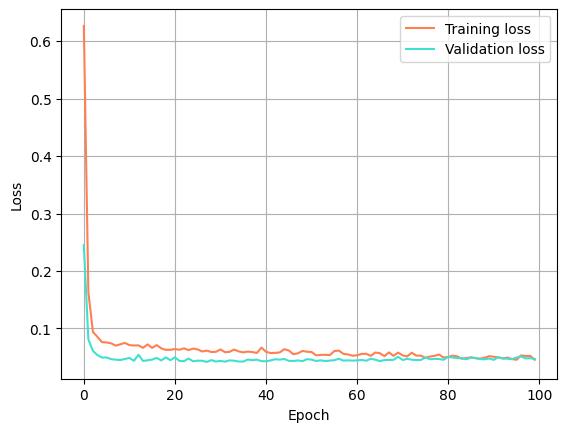

In [9]:
# Plot losses vs epochs
plt.plot(np.arange(num_epochs), hold_loss, label = "Training loss", c = "coral")
plt.plot(np.arange(num_epochs), hold_val_loss, label = "Validation loss", c = "turquoise")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()

In [10]:
## Calculate Hessian at the minimum along with its spectrum and eigenvectors
# Run all training data through the model
train_dataloader_for_H = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)

for inputs, labels in train_dataloader_for_H:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)

hessian = find_hessian(loss, model)
print("Computing eigenvalues")
heigenvalues = np.linalg.eigvalsh(hessian)

Calculating hessian: 100%|██████████| 10703/10703 [00:58<00:00, 183.84it/s]


Computing eigenvalues and eigenvectors


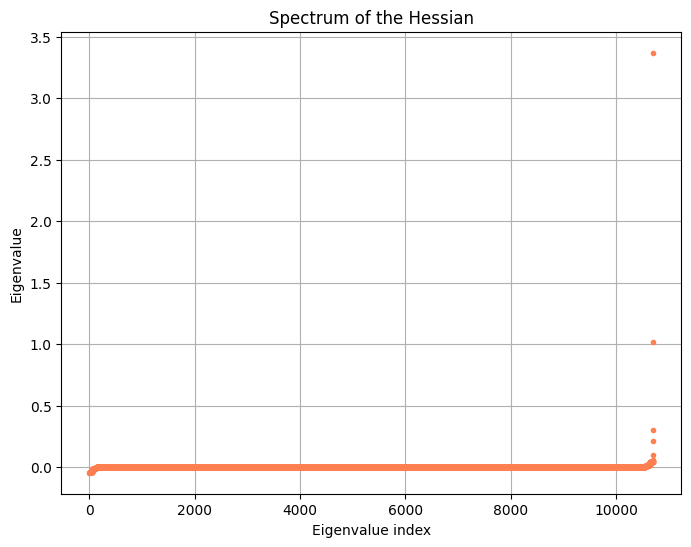

In [13]:
# Plot the Hessian spectrum
plt.figure(figsize=(8, 6))
plt.plot(heigenvalues, 'o', markersize=3, color="coral")
plt.xlabel("Eigenvalue index")
plt.ylabel("Eigenvalue")
plt.title("Spectrum of the Hessian")
plt.grid()
plt.show()

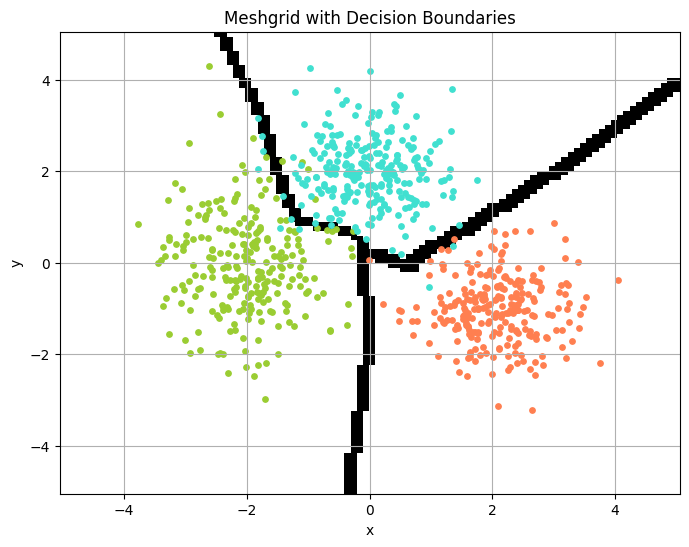

In [12]:
# Plot the decision boundary and training data
X1, X2, grid_data = generate_grid_data(-5, 5, -5, 5, 100, 100)
with torch.no_grad():
  grid_data = torch.tensor(grid_data, dtype=torch.float32).to(device)
  Y = model(grid_data)
  Y = Y.argmax(axis=1).cpu().numpy().reshape(X1.shape)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
plt.grid()

show_decision_boundaries(ax, X1, X2, Y)
show_training_points(ax, train_dataset)

plt.title('Meshgrid with Decision Boundaries')
plt.xlabel('x')
plt.ylabel('y')
plt.show()